In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [3]:
import numpy as np
import pandas as pd
import datetime as dt
from pprint import pprint

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc

In [6]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [8]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).\
    order_by(desc(Measurement.date)).first()[0]
print(recent_date)

2017-08-23


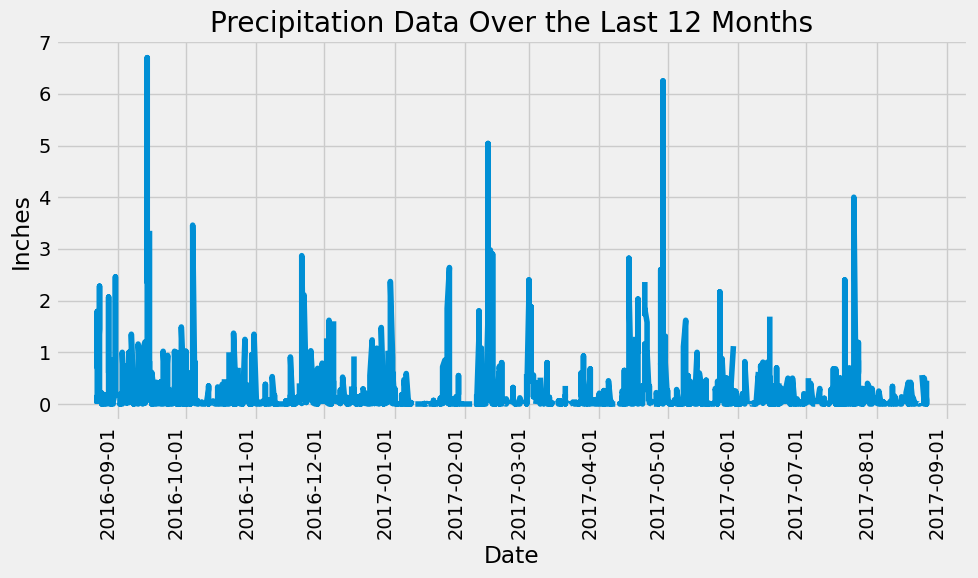

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= '2016-08-23').\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
last_year_df = pd.DataFrame(precipitation_data, columns=['date', 'precipitation'])

# Sort the dataframe by date
last_year_df['date'] = pd.to_datetime(last_year_df['date'])
last_year_df = last_year_df.sort_values(by='date')

# Use Pandas Plotting with Matplotlib to plot the data
last_year_df.set_index('date', inplace=True)

# Plot using DataFrame.plot
ax = last_year_df['precipitation'].plot(figsize=(10, 6), title='Precipitation Data Over the Last 12 Months')
ax.set_xlabel('Date')
ax.set_ylabel('Inches')
ax.grid(True)

# Show ticks every month
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=90)

# Display the plot
plt.tight_layout()
plt.show()

In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = last_year_df['precipitation'].describe()
summary_statistics_df = pd.DataFrame(summary_statistics)
summary_statistics_df

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [16]:
# Design a query to calculate the total number of stations in the dataset

# Print the column names so we know what column to call (commented out to declutter outputs)
# for column in Station.__table__.columns:
#     print(column.name)

# Find the count of station IDs
total_stations = session.query(func.count(Station.id)).all()
print(total_stations)

[(9,)]


In [17]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_counts = (
    session.query(Measurement.station, func.count(Measurement.station).label('count'))
    .group_by(Measurement.station)
    .order_by(desc('count'))
    .all()
)

pprint(station_counts)

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]


In [18]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_temps = session.query(
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)
).filter(Measurement.station == 'USC00519281').all()

print(most_active_temps)

[(54.0, 85.0, 71.66378066378067)]


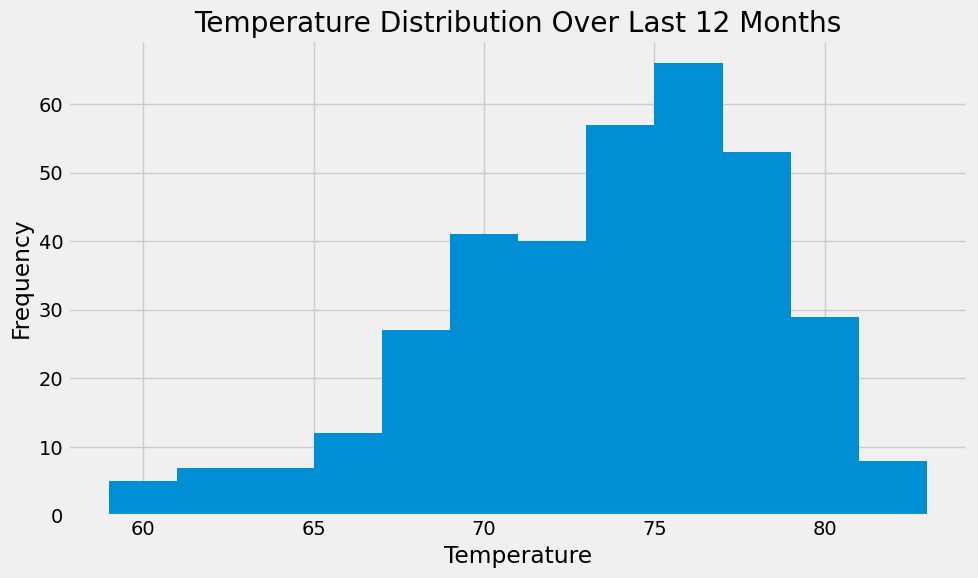

In [19]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_last_year = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date >= '2016-08-23').\
    filter(Measurement.station == 'USC00519281').\
    all()

# Save query results to a pandas DataFrame
temps_df = pd.DataFrame(temperature_last_year, columns=['date', 'tobs'])

# Plot histogram using the DataFrame
temps_df['tobs'].plot(kind='hist', bins=12, figsize=(10, 6))

# Set labels
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Temperature Distribution Over Last 12 Months')
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()

# Close Session

In [21]:
# Close Session
session.close()